# Initialize a game

In [1]:
from ConnectN import ConnectN

game_setting = {'size':(6,6), 'N':4, 'pie_rule':True}
game = ConnectN(**game_setting)


<IPython.core.display.Javascript object>


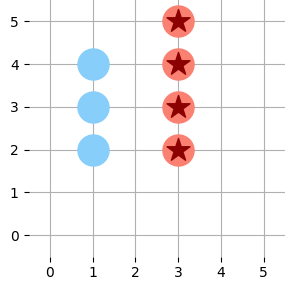

In [2]:
%matplotlib notebook

from Play import Play


gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=None)


# Define our policy

Please go ahead and define your own policy! See if you can train it under 1000 games and with only 1000 steps of exploration in each move.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np

from ConnectN import ConnectN
game_setting = {'size':(6,6), 'N':4}
game = ConnectN(**game_setting)

class Policy(nn.Module):

    def __init__(self, game):
        super(Policy, self).__init__()

        # input = 6x6 board
        # convert to 5x5x16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        # 5x5x16 to 3x3x32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, bias=False)

        self.size=3*3*32
        
        # the part for actions
        self.fc_action1 = nn.Linear(self.size, self.size//4)
        self.fc_action2 = nn.Linear(self.size//4, 36)
        
        # the part for the value function
        self.fc_value1 = nn.Linear(self.size, self.size//6)
        self.fc_value2 = nn.Linear(self.size//6, 1)
        self.tanh_value = nn.Tanh()
        
    def forward(self, x):

        y = F.leaky_relu(self.conv1(x))
        y = F.leaky_relu(self.conv2(y))
        y = y.view(-1, self.size)
        
        # action head
        a = self.fc_action2(F.leaky_relu(self.fc_action1(y)))
        
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
        avail = avail.reshape(-1, 36)
        maxa = torch.max(a)
        exp = avail*torch.exp(a-maxa)
        prob = exp/torch.sum(exp)
        
        # value head
        value = self.tanh_value(self.fc_value2(F.leaky_relu( self.fc_value1(y) )))
        return prob.view(6,6), value

policy = Policy(game)


# Define a MCTS player for Play

In [5]:
import MCTS

from copy import copy

def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(2000):
        mytree.explore(policy)
       
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    return mytreenext.game.last_move

import random

def Random_Player(game):
    return random.choice(game.available_moves())    


# Play a game against a random policy


<IPython.core.display.Javascript object>


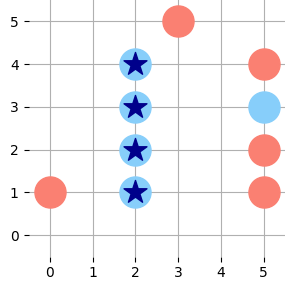

/home/sagarnildass/python_notebooks/Udacity-Deep-Reinforcement-Learning/my_codes/AlphaZeroTicTacToe/MCTS.py:70: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return game.available_moves(), tinv(prob)[mask].view(-1), v.squeeze().squeeze()


In [6]:
%matplotlib notebook

from Play import Play


gameplay=Play(ConnectN(**game_setting), 
              player1=Policy_Player_MCTS, 
              player2=None)


# Training


In [7]:
# initialize our alphazero agent and optimizer
import torch.optim as optim


game=ConnectN(**game_setting)
policy = Policy(game)
optimizer = optim.Adam(policy.parameters(), lr=.005, weight_decay=1.e-5)


In [8]:
# train our agent

from collections import deque
import MCTS

# try a higher number
episodes = 50000

import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

outcomes = []
policy_loss = []

Nmax = 2000

for e in range(1, episodes+1):

    mytree = MCTS.Node(game)
    logterm = []
    vterm = []
    
    while mytree.outcome is None:
        for _ in range(Nmax):
            mytree.explore(policy)
            if mytree.N >= Nmax:
                break
            
        current_player = mytree.game.player
        mytree, (v, nn_v, p, nn_p) = mytree.next()
        mytree.detach_mother()
        
        loglist = torch.log(nn_p)*p
        constant = torch.where(p>0, p*torch.log(p),torch.tensor(0.))
        logterm.append(-torch.sum(loglist-constant))

        vterm.append(nn_v*current_player)
        
    # we compute the "policy_loss" for computing gradient
    outcome = mytree.outcome
    outcomes.append(outcome)
    
    loss = torch.sum( (torch.stack(vterm)-outcome)**2 + torch.stack(logterm) )
    optimizer.zero_grad()
    loss.backward()
    policy_loss.append(float(loss))

    optimizer.step()
    
    if e%100==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(policy_loss[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    
    if e%500==0:
        torch.save(policy,'6-6-4-pie-{:d}.policy'.format(e))
    del loss
    
    timer.update(e+1)
    
timer.finish()

/home/sagarnildass/anaconda3/envs/mlagents_unity/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


game:  101 , mean loss: 11.08 , recent outcomes:  [1, 1, -1, 1, 1, -1, 1, 1, 1, 1]


game:  201 , mean loss: 3.58 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  301 , mean loss: 4.33 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, -1, 1]


game:  401 , mean loss: 1.64 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  501 , mean loss: 0.60 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  601 , mean loss: 0.38 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  701 , mean loss: 0.33 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  801 , mean loss: 3.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  901 , mean loss: 3.46 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  1001 , mean loss: 4.91 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  1101 , mean loss: 1.89 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  1201 , mean loss: 0.43 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  1301 , mean loss: 1.55 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  1401 , mean loss: 0.24 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  1501 , mean loss: 0.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  1601 , mean loss: 0.17 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  1701 , mean loss: 0.14 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  1801 , mean loss: 1.49 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  1901 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  2001 , mean loss: 6.00 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  2101 , mean loss: 22.35 , recent outcomes:  [1, -1, -1, -1, -1, -1, -1, 1, 1, -1]


game:  2201 , mean loss: 19.19 , recent outcomes:  [1, 1, 1, 1, 1, 1, -1, 1, 1, 0]


game:  2301 , mean loss: 22.40 , recent outcomes:  [1, 1, 1, 1, -1, 1, 1, -1, 1, 1]


game:  2401 , mean loss: 27.82 , recent outcomes:  [1, 1, 0, 0, -1, 1, 0, 1, 0, -1]


game:  2501 , mean loss: 10.05 , recent outcomes:  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


game:  2601 , mean loss: 5.45 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  2701 , mean loss: 2.35 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  2801 , mean loss: 1.60 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  2901 , mean loss: 6.69 , recent outcomes:  [1, 1, 1, 1, 1, -1, 1, 1, 1, 1]


game:  3001 , mean loss: 1.23 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  3101 , mean loss: 7.14 , recent outcomes:  [1, 1, 1, 1, -1, 1, 1, 1, 1, 1]


game:  3201 , mean loss: 1.06 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  3301 , mean loss: 3.06 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  3401 , mean loss: 2.86 , recent outcomes:  [1, 1, 1, -1, 1, 1, 1, 1, 1, 1]


game:  3501 , mean loss: 3.52 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  3601 , mean loss: 1.23 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  3701 , mean loss: 5.78 , recent outcomes:  [1, 1, 1, 1, 1, -1, 1, 1, 1, 1]


game:  3801 , mean loss: 0.80 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  3901 , mean loss: 1.71 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  4001 , mean loss: 2.85 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  4101 , mean loss: 2.78 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  4201 , mean loss: 1.99 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  4301 , mean loss: 3.73 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


game:  4401 , mean loss: 0.45 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  4501 , mean loss: 0.62 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  4601 , mean loss: 3.04 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  4701 , mean loss: 2.88 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


game:  4801 , mean loss: 0.39 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  4901 , mean loss: 0.32 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  5001 , mean loss: 2.15 , recent outcomes:  [1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


game:  5101 , mean loss: 0.58 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  5201 , mean loss: 0.36 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  5301 , mean loss: 3.65 , recent outcomes:  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


game:  5401 , mean loss: 4.35 , recent outcomes:  [1, 1, 1, 1, 0, 1, 1, -1, 1, 1]


game:  5501 , mean loss: 2.56 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, -1, 1]


game:  5601 , mean loss: 1.40 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  5701 , mean loss: 0.44 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  5801 , mean loss: 0.85 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  5901 , mean loss: 0.92 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  6001 , mean loss: 2.60 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  6101 , mean loss: 3.99 , recent outcomes:  [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  6201 , mean loss: 1.04 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  6301 , mean loss: 0.28 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  6401 , mean loss: 0.57 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  6501 , mean loss: 2.23 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  6601 , mean loss: 0.52 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  6701 , mean loss: 0.52 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  6801 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  6901 , mean loss: 0.33 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  7001 , mean loss: 0.19 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  7101 , mean loss: 2.26 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, -1, 1, 1]


game:  7201 , mean loss: 0.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  7301 , mean loss: 0.18 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  7401 , mean loss: 0.34 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  7501 , mean loss: 0.40 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  7601 , mean loss: 3.52 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  7701 , mean loss: 2.31 , recent outcomes:  [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  7801 , mean loss: 4.11 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  7901 , mean loss: 8.13 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, -1, 1]


game:  8001 , mean loss: 0.52 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  8101 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  8201 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  8301 , mean loss: 0.50 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  8401 , mean loss: 0.28 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  8501 , mean loss: 1.51 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  8601 , mean loss: 4.29 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  8701 , mean loss: 1.44 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  8801 , mean loss: 0.83 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  8901 , mean loss: 0.48 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  9001 , mean loss: 0.64 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  9101 , mean loss: 0.45 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  9201 , mean loss: 0.84 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  9301 , mean loss: 2.77 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  9401 , mean loss: 0.44 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  9501 , mean loss: 0.30 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  9601 , mean loss: 8.59 , recent outcomes:  [1, -1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  9701 , mean loss: 2.54 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  9801 , mean loss: 0.26 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  9901 , mean loss: 0.18 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  10001 , mean loss: 0.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  10101 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  10201 , mean loss: 0.47 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  10301 , mean loss: 0.82 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  10401 , mean loss: 0.61 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  10501 , mean loss: 0.43 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  10601 , mean loss: 0.52 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  10701 , mean loss: 1.90 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  10801 , mean loss: 4.68 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, -1]


game:  10901 , mean loss: 0.65 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  11001 , mean loss: 0.81 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  11101 , mean loss: 3.74 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  11201 , mean loss: 0.48 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  11301 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  11401 , mean loss: 0.42 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  11501 , mean loss: 0.46 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  11601 , mean loss: 0.42 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  11701 , mean loss: 0.68 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  11801 , mean loss: 5.69 , recent outcomes:  [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  11901 , mean loss: 0.76 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  12001 , mean loss: 3.49 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  12101 , mean loss: 0.47 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  12201 , mean loss: 0.30 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  12301 , mean loss: 5.91 , recent outcomes:  [1, 1, 1, 1, 1, 1, -1, 1, 1, 1]


game:  12401 , mean loss: 0.49 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  12501 , mean loss: 0.43 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  12601 , mean loss: 0.43 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  12701 , mean loss: 0.22 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  12801 , mean loss: 0.20 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  12901 , mean loss: 2.40 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  13001 , mean loss: 4.68 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  13101 , mean loss: 0.52 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  13201 , mean loss: 1.41 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  13301 , mean loss: 1.02 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  13401 , mean loss: 1.22 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  13501 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  13601 , mean loss: 2.49 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  13701 , mean loss: 0.25 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  13801 , mean loss: 1.07 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  13901 , mean loss: 1.98 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, -1, 1, 1]


game:  14001 , mean loss: 0.23 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  14101 , mean loss: 0.54 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  14201 , mean loss: 0.15 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  14301 , mean loss: 0.24 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  14401 , mean loss: 1.63 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, -1, 1]


game:  14501 , mean loss: 3.19 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  14601 , mean loss: 0.79 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  14701 , mean loss: 0.20 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  14801 , mean loss: 2.24 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  14901 , mean loss: 0.20 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  15001 , mean loss: 0.24 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  15101 , mean loss: 0.19 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  15201 , mean loss: 1.65 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  15301 , mean loss: 1.53 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  15401 , mean loss: 0.43 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  15501 , mean loss: 0.30 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  15601 , mean loss: 0.46 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  15701 , mean loss: 0.44 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  15801 , mean loss: 0.40 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  15901 , mean loss: 0.52 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  16001 , mean loss: 0.32 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  16101 , mean loss: 0.23 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  16201 , mean loss: 0.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  16301 , mean loss: 0.30 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  16401 , mean loss: 1.10 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  16501 , mean loss: 0.29 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  16601 , mean loss: 0.66 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  16701 , mean loss: 0.36 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  16801 , mean loss: 0.24 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  16901 , mean loss: 0.23 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  17001 , mean loss: 4.28 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  17101 , mean loss: 0.50 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  17201 , mean loss: 1.68 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  17301 , mean loss: 3.26 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  17401 , mean loss: 2.12 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  17501 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  17601 , mean loss: 3.22 , recent outcomes:  [1, 1, 1, -1, 1, 1, 1, 1, 1, 1]


game:  17701 , mean loss: 0.45 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  17801 , mean loss: 0.25 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  17901 , mean loss: 0.25 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  18001 , mean loss: 0.20 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  18101 , mean loss: 0.26 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  18201 , mean loss: 0.16 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  18301 , mean loss: 0.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  18401 , mean loss: 6.35 , recent outcomes:  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  18501 , mean loss: 0.26 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  18601 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  18701 , mean loss: 0.77 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  18801 , mean loss: 0.33 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  18901 , mean loss: 0.29 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  19001 , mean loss: 0.22 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  19101 , mean loss: 2.71 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  19201 , mean loss: 0.30 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  19301 , mean loss: 0.39 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  19401 , mean loss: 0.25 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  19501 , mean loss: 0.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  19601 , mean loss: 0.20 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  19701 , mean loss: 0.73 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  19801 , mean loss: 0.43 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  19901 , mean loss: 5.80 , recent outcomes:  [1, -1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  20001 , mean loss: 0.28 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  20101 , mean loss: 0.23 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  20201 , mean loss: 1.54 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  20301 , mean loss: 2.96 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  20401 , mean loss: 0.67 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  20501 , mean loss: 0.43 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  20601 , mean loss: 0.34 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  20701 , mean loss: 0.37 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  20801 , mean loss: 5.56 , recent outcomes:  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


game:  20901 , mean loss: 0.35 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  21001 , mean loss: 3.12 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  21101 , mean loss: 0.55 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  21201 , mean loss: 2.02 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  21301 , mean loss: 0.94 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  21401 , mean loss: 3.90 , recent outcomes:  [1, -1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  21501 , mean loss: 0.51 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  21601 , mean loss: 2.87 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  21701 , mean loss: 0.46 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  21801 , mean loss: 0.49 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  21901 , mean loss: 0.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  22001 , mean loss: 0.23 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  22101 , mean loss: 0.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  22201 , mean loss: 0.57 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  22301 , mean loss: 0.42 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  22401 , mean loss: 4.16 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  22501 , mean loss: 5.83 , recent outcomes:  [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  22601 , mean loss: 4.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  22701 , mean loss: 0.92 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  22801 , mean loss: 3.01 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, -1]


game:  22901 , mean loss: 0.82 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  23001 , mean loss: 1.05 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  23101 , mean loss: 0.58 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  23201 , mean loss: 7.28 , recent outcomes:  [1, -1, -1, 1, 1, 1, 1, 1, 1, 1]


game:  23301 , mean loss: 0.55 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  23401 , mean loss: 0.30 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  23501 , mean loss: 0.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  23601 , mean loss: 0.32 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  23701 , mean loss: 0.30 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  23801 , mean loss: 0.44 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  23901 , mean loss: 0.25 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  24001 , mean loss: 1.92 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  24101 , mean loss: 2.19 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  24201 , mean loss: 2.10 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, -1, 1, 1]


game:  24301 , mean loss: 0.77 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  24401 , mean loss: 1.53 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  24501 , mean loss: 3.78 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  24601 , mean loss: 0.57 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  24701 , mean loss: 0.80 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  24801 , mean loss: 2.91 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, -1, 1, 1]


game:  24901 , mean loss: 0.33 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  25001 , mean loss: 5.85 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  25101 , mean loss: 1.04 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  25201 , mean loss: 0.51 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  25301 , mean loss: 0.40 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  25401 , mean loss: 0.83 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  25501 , mean loss: 1.41 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  25601 , mean loss: 0.39 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  25701 , mean loss: 0.38 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  25801 , mean loss: 0.34 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  25901 , mean loss: 0.47 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  26001 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  26101 , mean loss: 0.36 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  26201 , mean loss: 4.98 , recent outcomes:  [1, -1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  26301 , mean loss: 0.38 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  26401 , mean loss: 5.34 , recent outcomes:  [1, 1, 1, -1, 1, 1, 1, 1, 0, 1]


game:  26501 , mean loss: 0.43 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  26601 , mean loss: 4.51 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  26701 , mean loss: 0.32 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  26801 , mean loss: 0.63 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  26901 , mean loss: 0.24 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  27001 , mean loss: 0.25 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/home/sagarnildass/python_notebooks/Udacity-Deep-Reinforcement-Learning/my_codes/AlphaZeroTicTacToe/MCTS.py:106: SyntaxWarning: "is" with a literal. Did you mean "=="?
  self.U = 0 if self.game.score is 0 else self.V*float('inf')
/home/sagarnildass/python_notebooks/Udacity-Deep-Reinforcement-Learning/my_codes/AlphaZeroTicTacToe/MCTS.py:106: SyntaxWarning: "is" with a literal. Did you mean "=="?
  self.U = 0 if self.game.score is 0 else self.V*float('inf')
/home/sagarnildass/python_notebooks/Udacity-Deep-Reinforcement-Learning/my_codes/AlphaZeroTicTacToe/MCTS.py:106: SyntaxWarning: "is" with a literal. Did you mean "=="?
  self.U = 0 if self.game.score is 0 else self.V*float('inf')
/home/sagarnildass/python_notebooks/Udacity-Deep-Reinforcement-Learning/my_codes/AlphaZeroTicTacToe/MCTS.py:106: SyntaxWarning: "is" with a literal. Did you mean "=="?
  self.U = 0 if self.game.score is 0 else self.V*float('inf')


KeyboardInterrupt: 

# setup environment to pit your AI against the challenge policy '6-6-4-pie.policy'

In [ ]:
challenge_policy = torch.load('6-6-4-pie-4500.mypolicy')

def Challenge_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(1000):
        mytree.explore(challenge_policy)
       
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    return mytreenext.game.last_move



# Let the game begin!

In [ ]:
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Challenge_Player_MCTS)